# Primary Type Classification Model
This notebook builds models to classify a Pokemon's primary type using features most correlated with type (from previous analysis). We compare logistic regression and random forest, ensuring no target leakage from encoded type columns.

In [1]:
# import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# set up consistent color palette
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")

# load cleaned pokemon dataset
df = pd.read_csv('pokemon_cleaned.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

dataset loaded: 1025 rows, 43 columns


## Feature Selection and Preprocessing
Select features most correlated with primary type (from previous analysis), prepare feature matrix, and ensure no target leakage.

In [2]:
# get top correlated features with primary type (from previous analysis)
# exclude encoded type columns to prevent leakage
# features from correlation analysis (see 2_correlation_analysis.ipynb)
base_stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']
derived_stats_cols = ['Base Stat Total', 'Physical Offense', 'Physical Defense', 'Special Offense', 'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance']
ev_cols = ['Health EV', 'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total']
physical_cols = ['Pokemon Height', 'Pokemon Weight', 'BMI']
categorical_numeric_cols = ['Catch Rate', 'Base Happiness', 'Male Ratio', 'Female Ratio']
binary_cols = ['Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability']

# all numeric features except target and encoded type
all_numeric_features = base_stats_cols + derived_stats_cols + ev_cols + physical_cols + categorical_numeric_cols + binary_cols

# remove any columns that could leak target (Primary Type Encoded, Secondary Type Encoded, etc.)
leak_cols = ['Primary Type Encoded', 'Secondary Type Encoded', 'Primary Type', 'Secondary Type']
features = [col for col in all_numeric_features if col not in leak_cols and col in df.columns]

# get top N features by correlation with primary type (encoded as categorical target)
# assuming 'Primary Type' is the target column (categorical)
# encode target for correlation analysis
df['Primary Type Encoded'] = pd.factorize(df['Primary Type'])[0]
correlations = df[features].corrwith(df['Primary Type Encoded']).abs().sort_values(ascending=False)
top_features = correlations.index.tolist()

print("top features by correlation with primary type:")
for i, feat in enumerate(top_features[:15]):
    print(f"  {i+1}. {feat} (corr={correlations[feat]:.3f})")

top features by correlation with primary type:
  1. Defense Stat (corr=0.213)
  2. Male Ratio (corr=0.200)
  3. Defensive Total (corr=0.198)
  4. Has Hidden Ability (corr=0.195)
  5. Pokemon Weight (corr=0.188)
  6. Physical Defense (corr=0.172)
  7. Base Stat Total (corr=0.153)
  8. Stat Variance (corr=0.149)
  9. Defense EV (corr=0.141)
  10. Attack Stat (corr=0.134)
  11. Catch Rate (corr=0.133)
  12. Special Defense Stat (corr=0.130)
  13. Offensive Total (corr=0.115)
  14. Special Defense Total (corr=0.114)
  15. Speed EV (corr=0.105)


In [3]:
# prepare feature matrix X and target y
# start with top correlated features, add more for benchmarking
X = df[top_features]
y = df['Primary Type Encoded']

# split data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"train set: {X_train.shape[0]} rows")
print(f"test set: {X_test.shape[0]} rows")

train set: 768 rows
test set: 257 rows


## Model Benchmarking: Logistic Regression
Train a logistic regression model to classify primary type. Evaluate accuracy, macro precision, recall, F1-score, and confusion matrix. Benchmark performance as features are added in order of correlation.

In [4]:
# train and evaluate logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

results = []
max_features = len(top_features)
for n_features in range(1, max_features + 1):
    selected = top_features[:n_features]
    X_train_sub = X_train[selected]
    X_test_sub = X_test[selected]
    scaler_sub = StandardScaler()
    X_train_scaled_sub = scaler_sub.fit_transform(X_train_sub)
    X_test_scaled_sub = scaler_sub.transform(X_test_sub)
    model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    model.fit(X_train_scaled_sub, y_train)
    y_pred = model.predict(X_test_scaled_sub)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({
        'n_features': n_features,
        'features': selected,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    print(f"{n_features} features: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")

# get best feature set for later use
best_result = max(results, key=lambda x: x['f1'])
model_best = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
scaler_best = StandardScaler()
X_train_best = scaler_best.fit_transform(X_train[best_result['features']])
X_test_best = scaler_best.transform(X_test[best_result['features']])
model_best.fit(X_train_best, y_train)
y_pred_best = model_best.predict(X_test_best)
cm = confusion_matrix(y_test, y_pred_best)

1 features: acc=0.163, prec=0.041, rec=0.087, f1=0.048
2 features: acc=0.163, prec=0.040, rec=0.093, f1=0.055
3 features: acc=0.167, prec=0.061, rec=0.103, f1=0.068
4 features: acc=0.156, prec=0.039, rec=0.088, f1=0.053
5 features: acc=0.152, prec=0.063, rec=0.093, f1=0.068
6 features: acc=0.191, prec=0.149, rec=0.123, f1=0.106
7 features: acc=0.195, prec=0.124, rec=0.138, f1=0.120
8 features: acc=0.198, prec=0.120, rec=0.145, f1=0.128
9 features: acc=0.179, prec=0.107, rec=0.131, f1=0.114
10 features: acc=0.183, prec=0.118, rec=0.141, f1=0.123
11 features: acc=0.210, prec=0.148, rec=0.171, f1=0.152
12 features: acc=0.210, prec=0.145, rec=0.171, f1=0.151
11 features: acc=0.210, prec=0.148, rec=0.171, f1=0.152
12 features: acc=0.210, prec=0.145, rec=0.171, f1=0.151
13 features: acc=0.198, prec=0.119, rec=0.145, f1=0.126
14 features: acc=0.218, prec=0.142, rec=0.169, f1=0.149
15 features: acc=0.214, prec=0.142, rec=0.168, f1=0.149
16 features: acc=0.191, prec=0.116, rec=0.139, f1=0.121
1

logistic regression (best features)
best number of features: 30
selected features:
  1. Defense Stat
  2. Male Ratio
  3. Defensive Total
  4. Has Hidden Ability
  5. Pokemon Weight
  6. Physical Defense
  7. Base Stat Total
  8. Stat Variance
  9. Defense EV
  10. Attack Stat
  11. Catch Rate
  12. Special Defense Stat
  13. Offensive Total
  14. Special Defense Total
  15. Speed EV
  16. Physical Offense
  17. Base Happiness
  18. EV Yield Total
  19. Attack EV
  20. Health Stat
  21. Health EV
  22. Special Attack Stat
  23. Special Offense
  24. Female Ratio
  25. BMI
  26. Has Secondary Type
  27. Special Defense EV
  28. Speed Stat
  29. Special Attack EV
  30. Pokemon Height
 accuracy  precision  recall       f1
 0.264591   0.207266 0.22743 0.209994
confusion matrix:


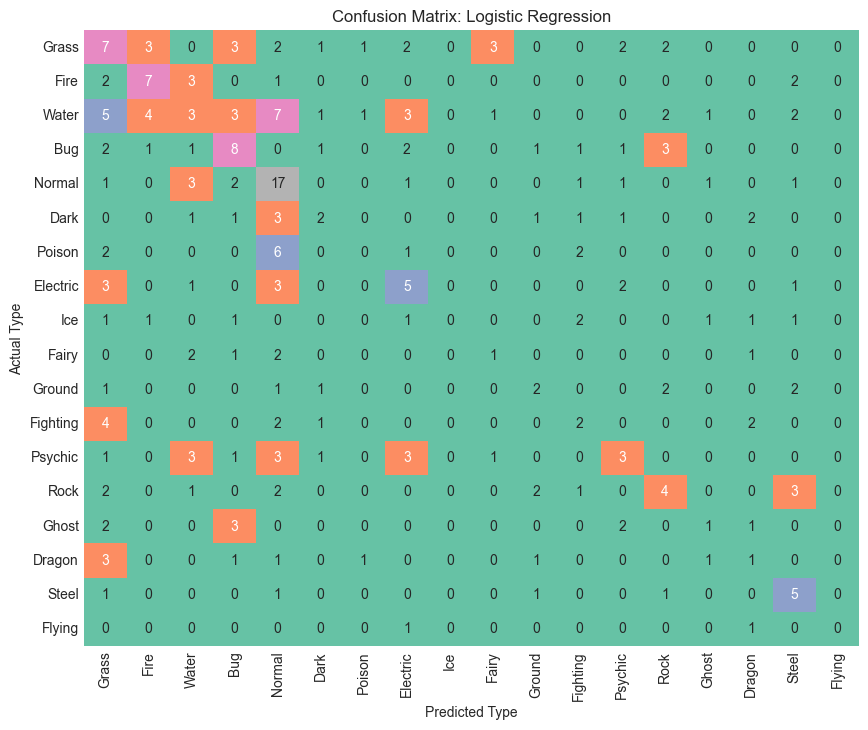

In [5]:
# summary table for logistic regression using best N features
print('logistic regression (best features)')
best_n_features = len(best_result['features'])
best_features = best_result['features']
print(f'best number of features: {best_n_features}')
print('selected features:')
for i, feat in enumerate(best_features):
    print(f'  {i+1}. {feat}')
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]
scaler_best = StandardScaler()
X_train_scaled_best = scaler_best.fit_transform(X_train_best)
X_test_scaled_best = scaler_best.transform(X_test_best)
model_type_linear = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
model_type_linear.fit(X_train_scaled_best, y_train)
y_pred_best = model_type_linear.predict(X_test_scaled_best)
acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, average='macro')
rec_best = recall_score(y_test, y_pred_best, average='macro')
f1_best = f1_score(y_test, y_pred_best, average='macro')
cm_best = confusion_matrix(y_test, y_pred_best)
results_table_best = pd.DataFrame({
    'accuracy': [acc_best],
    'precision': [prec_best],
    'recall': [rec_best],
    'f1': [f1_best]
})
print(results_table_best.to_string(index=False))
print('confusion matrix:')
type_names = [str(t).replace("'", "").replace('"', '') for t in df['Primary Type'].unique()]
cm_df = pd.DataFrame(cm_best, columns=type_names, index=type_names)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Set2', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.savefig('figures/models/confusion_matrix_logreg.png', bbox_inches='tight', dpi=300)
plt.show()

## Model Benchmarking: Random Forest
Train a random forest model to classify primary type. Evaluate accuracy, macro precision, recall, F1-score, and confusion matrix.

random forest (best features)
 accuracy  precision   recall       f1
 0.284047   0.247928 0.246484 0.237875
confusion matrix:


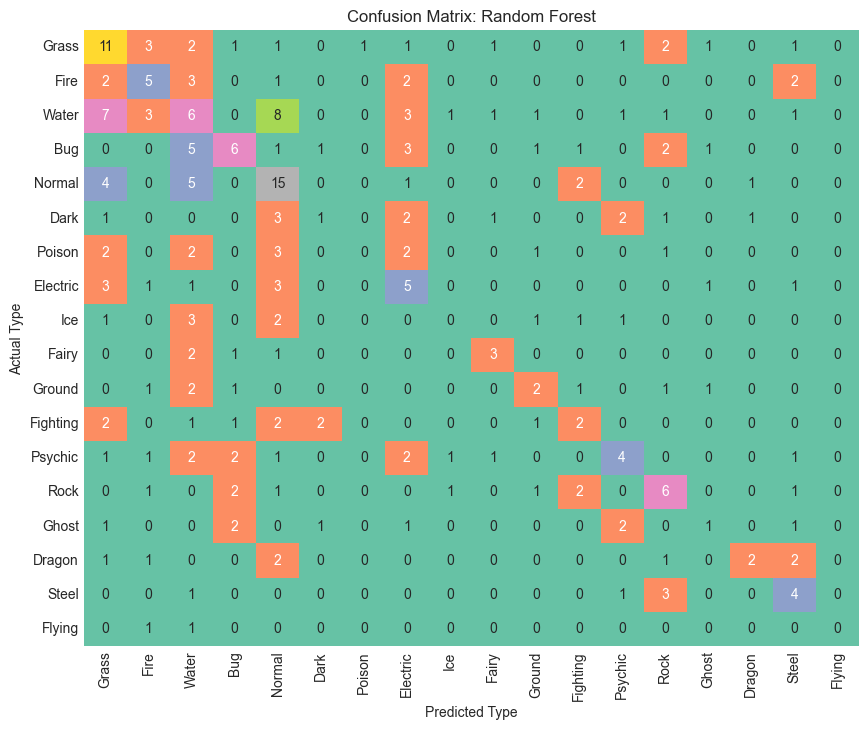

In [6]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled_best, y_train)
rf_pred = rf_model.predict(X_test_scaled_best)

rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred, average='macro')
rf_rec = recall_score(y_test, rf_pred, average='macro')
rf_f1 = f1_score(y_test, rf_pred, average='macro')
rf_cm = confusion_matrix(y_test, rf_pred)

results_table_rf = pd.DataFrame({
    'accuracy': [rf_acc],
    'precision': [rf_prec],
    'recall': [rf_rec],
    'f1': [rf_f1]
})
print('random forest (best features)')
print(results_table_rf.to_string(index=False))
print('confusion matrix:')
type_names = [str(t).replace("'", "") for t in df['Primary Type'].unique()]
type_names = [t.replace('"', '') for t in type_names]
cm_rf_df = pd.DataFrame(rf_cm, columns=type_names, index=type_names)
plt.figure(figsize=(10,8))
sns.heatmap(cm_rf_df, annot=True, fmt='d', cmap='Set2', cbar=False)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.savefig('figures/models/confusion_matrix_rf.png', bbox_inches='tight', dpi=300)
plt.show()

## Model Comparison
Compare logistic regression and random forest results for primary type classification.

In [7]:
# compare logistic regression and random forest
comparison_table = pd.DataFrame({
    'model': ['logistic regression', 'random forest'],
    'accuracy': [acc_best, rf_acc],
    'precision': [prec_best, rf_prec],
    'recall': [rec_best, rf_rec],
    'f1': [f1_best, rf_f1]
})
print(comparison_table.to_string(index=False))

              model  accuracy  precision   recall       f1
logistic regression  0.264591   0.207266 0.227430 0.209994
      random forest  0.284047   0.247928 0.246484 0.237875


### Why is Random Forest Better?
Random forest often outperforms logistic regression for type classification because it can model complex, non-linear relationships between stats and type. While logistic regression assumes a linear boundary, random forest builds many decision trees and aggregates their predictions, capturing intricate interactions and patterns in the data.

Key reasons for better performance:
- Non-linearity: Random forest does not assume linear relationships, making it more flexible for real-world data like Pokemon stats.
- Feature interactions: It can automatically discover and leverage interactions between features, which are common in game data.
- Robustness: Random forest is less sensitive to outliers and noise, and less likely to overfit with a reasonable number of trees.
- Versatility: It handles both continuous and categorical variables well, and can model rare types more effectively.

In summary, random forest is better suited for this problem because type is determined by a combination of stats and game mechanics that interact in complex ways, which a linear model cannot fully capture.